# Data Preprocessing and QC

In [6]:
### First install and import packages if missing
# %pip install polars
# %pip install matplotlib
# %pip install seaborn
# %pip install pyarrow

### Restart Kernel then import packages
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa
import pandas as pd
%matplotlib inline

## 1. Loading Pillar Project Data

In [7]:
pillar_clinvar_df = pl.read_csv(
    "../1_inputs/raw_inputs/pillar_data/pillar_data_clinvar38_053125_wREVEL_gold_standards.csv", 
    schema_overrides={
        "Chrom": pl.String, 
        'aa_pos': pl.String, 
        'auth_reported_score': pl.String
    },
    infer_schema_length=10000
).with_columns(
    pl.col("Gene").str.replace_all(r"[^a-zA-Z0-9]", "").alias("Gene"),
    pl.col("hgvs_p").str.replace_all(r"[^a-zA-Z0-9\.]", "").alias("hgvs_p")
).with_columns(
    pl.col("Gene").str.replace_all("CHK2", "CHEK2").alias("Gene"),
    pl.col("Chrom").cast(pl.String).str.strip_chars().alias("Chrom"),
    pl.col("hg38_start").alias("nuc_loc"),
    pl.col("ref_allele").cast(pl.String).str.strip_chars().alias("ref_allele"),
    pl.col("alt_allele").cast(pl.String).str.strip_chars().alias("alt_allele")
).with_columns(
    pl.concat_str(
        [
            pl.col("Gene"),
            pl.col("hgvs_p").str.replace(r"^p\.", "") # remove leading "p." from hgvs_p
        ],
        separator="_"
    ).alias("gene_variant")
)
print("Original pillar dataset shape:", pillar_clinvar_df.shape)

## filter the SNP variants only
pillar_clinvar_single_aa_df = pillar_clinvar_df.filter(
    (pl.col("consequence").str.contains("sense")) & \
    (pl.col("ref_allele").str.len_chars()==1) & (pl.col("alt_allele").str.len_chars()==1) & \
    (pl.col("hg38_start").is_not_null()) & (pl.col("hg38_end").is_not_null())
).drop_nulls(subset="hgvs_p").with_columns(
    pl.col("hgvs_p").str.split(".").list.get(-1).alias("aa_change"),
    pl.lit(True).alias("pillar_tested")
)
print("Filtered missense/SNP pillar dataset shape:", pillar_clinvar_single_aa_df.shape)

pillar_clinvar_single_aa_df = pillar_clinvar_single_aa_df.sort(
    "gene_variant", "gnomad_MAF", descending=[False,False]
)
print("Number of unique genes:", pillar_clinvar_single_aa_df.unique(subset="Gene").shape[0])
print("Number of unique gene variants:", pillar_clinvar_single_aa_df.unique(subset="gene_variant").shape[0])
display(pillar_clinvar_single_aa_df) #.filter(pl.col("Ref_seq_transcript_ID").str.contains("NC_"))

Original pillar dataset shape: (1053945, 102)
Filtered missense/SNP pillar dataset shape: (121504, 104)
Number of unique genes: 33
Number of unique gene variants: 61091


,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,…,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant,aa_change,pillar_tested
i64,str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,bool
27534,"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""",null,null,"""148""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""-0.1191""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-2""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Cell viability""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.483509e6,"""ASPA_Ala148Asp""","""Ala148Asp""",true
8857,"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""",null,null,"""148""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""0.9495""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-1""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Fluorescence""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.483509e6,"""ASPA_Ala148Asp""","""Ala148Asp""",true
27540,"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""G""",null,"""443""",null,null,"""148""","""A""","""G""","""c.443C>G""","""p.Ala148Gly""","""missense_variant""","""0.1248""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00000657-a-2""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Cell viability""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.483509e6,"""ASPA_Ala148Gly""","""Ala148Gly""",true
8863,"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thyge

### Summary of Pillar Data

Text(0.5, 1.0, 'Number of variants per gene in Pillar Project dataset')

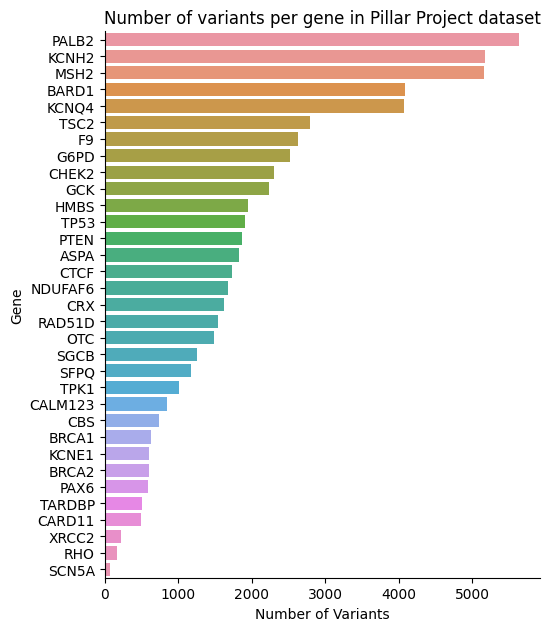

In [8]:
g = sns.catplot(data=pillar_clinvar_single_aa_df.unique(subset="gene_variant").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
            x="Number of Variants", y="Gene", kind="bar", height=6, aspect=.9)
plt.title("Number of variants per gene in Pillar Project dataset")

## 2. Loading VarChAMP consolidated dataset

### 2.1 OnePerc VarChAMP

In [9]:
def map_chr(num):
    if num == 23:
        return "X"
    elif num == 24:
        return "Y"
    elif num == 12920:
        return "MT"
    else:
        return str(num)


varchamp_seq_df = pl.read_csv("../1_inputs/VarChampSeqConfirmationResult.tsv", separator="\t")
varchamp_seq_df = varchamp_seq_df.with_columns(
    # pl.col("symbol").str.replace_all("NULL", "KCNE1").alias("symbol"),
    pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("gene_variant")
).with_columns(
    pl.col("spdi").str.extract(r"NC_0*([0-9]+)", 1).cast(pl.Int32).alias("chr_num"),
    pl.col("spdi").str.split(":").list.get(1).str.strip_chars().cast(pl.Float64).alias("nuc_loc"),
    pl.col("spdi").str.split(":").list.get(2).str.strip_chars().alias("ref_allele"),
    pl.col("spdi").str.split(":").list.get(3).str.strip_chars().alias("alt_allele"),
).with_columns(
    pl.col("chr_num")
    .map_elements(map_chr, return_dtype=pl.String)
    .str.strip_chars()
    .alias("Chrom")
)
varchamp_seq_df

# varchamp_seq_df["mutation_id_old"].unique()
# varchamp_seq_df.filter((pl.col("nuc_ref").str.len_chars()>1)|(pl.col("nuc_alt").str.len_chars()>1))
# varchamp_seq_df.unique(subset="gene_variant")

symbol,ensembl_gene_id,orf_id_wt,mutation_id_old,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,gene_variant,chr_num,nuc_loc,ref_allele,alt_allele,Chrom
str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,i64,str,i64,str,i64,str,i64,str,str,i32,f64,str,str,str
"""GBA1""","""ENSG00000177628""",2,6,"""CCSBVarC000001""","""ALE0000584""","""NC_000001.11:155240033:C:G""","""160G>C""","""Val54Leu""","""RC4""","""RC4_Mut_GDEh1026""","""H01""","""GDEhDisVCh_40054""","""F12""","""2""","""RC4_Mut_GDDh1026""","""H01""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",1,"""2""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""GBA1_Val54Leu""",1,1.55240033e8,"""C""","""G""","""1"""
"""GBA1""","""ENSG00000177628""",2,73,"""CCSBVarC000002""","""ALE00000002""","""NC_000001.11:155238225:G:A""","""670C>T""","""Leu224Phe""","""RC4""","""RC4_Mut_GDEh1026""","""E01""","""GDEhDisVCh_40054""","""C12""","""2""","""RC4_Mut_GDDh1026""","""E01""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",1,"""1""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""GBA1_Leu224Phe""",1,1.55238225e8,"""G""","""A""","""1"""
"""GBA1""","""ENSG00000177628""",2,113,"""CCSBVarC000003""","""ALE00000003""","""NC_000001.11:155237453:C:T""","""887G>A""","""Arg296Gln""","""RC4""","""RC4_Mut_GDEh1026""","""F01""","""GDEhDisVCh_40054""","""D12""","""2""","""RC4_Mut_GDDh1026""","""F01""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",1,"""7""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""GBA1_Arg296Gln""",1,1.55237453e8,"""C""","""T""","""1"""
"""GBA1""","""ENSG00000177628""",2,231,"""CCSBVarC000004""","""ALE00000004""","""NC_000001.11:155235252:A:G""","""1448T>C""","""Leu483Pro""","""RC4""","""RC4_Mut_GDEh1026""","""G01""","""GDEhDisVCh_40054""","""E12""","""2""","""RC4_Mut_GDDh1026""","""G01""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",1,"""2""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""GBA1_Leu483Pro""",1,1.55235252e8,"""A""","""G""","""1"""
"""GBA1""","""ENSG00000177628""",2,213510,"""CCSBVarC003869""","""ALE00003869""","""NC_000001.11:155239934:G:A""","""259C>T""","""Arg87Trp""","""CEGS2""","""CegsMutGDEh1035""","""B03""","""GDEhDisVCh_40054""","""B02""","""2""","""CegsMutGDDh1035""","""B03""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",1,"""2""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""GBA1_Arg87Trp""",1,1.55239934e8,"""G""","""A""","""1"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""CTNNB1""","""ENSG00000168036""",100070227,212487,"""CCSBVarC007073""","""ALE00007071""","""NC_000003.12:41225785:A:G""","""860A>G""","""Asn287Ser""","""CEGS2""","""CegsMutGDEh1023""","""B07""","""GDEhDisVCh_40034""","""E09""","""2""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",0,"""NULL""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""CTNNB1_Asn287Ser""",3,4.1225785e7,"""A""","""G""","""3"""
"""TBX19""","""ENSG00000143178""",100070258,212488,"""CCSBVarC007074""","""ALE00007072""","""NC_000001.11:168291339:C:T""","""383C>T""","""Ser128Phe""","""CEGS2""","""CegsMutGDEh1043""","""A07""","""GDEhDisVCh_40046""","""B02""","""2""","""CegsMutGDDh1043""","""A07""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""7""",1,"""7""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""TBX19_Ser128Phe""",1,1.68291339e8,"""C""","""T""","""1"""
"""TBX19""","""ENSG00000143178""",

In [19]:
# varchamp_seq_cons_df = pl.read_csv("../1_inputs/VarChamp_Consolidated_allele_collection.tsv", separator="\t", infer_schema_length=10000)
# varchamp_seq_cons_df = varchamp_seq_df.with_columns(
#     # pl.col("symbol").str.replace_all("NULL", "KCNE1").alias("symbol"),
#     pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("gene_variant")
# )
# .with_columns(
#     pl.col("spdi").str.extract(r"NC_0*([0-9]+)", 1).cast(pl.Int32).alias("chr_num"),
#     pl.col("spdi").str.split(":").list.get(1).str.strip_chars().cast(pl.Float64).alias("nuc_loc"),
#     pl.col("spdi").str.split(":").list.get(2).str.strip_chars().alias("ref_allele"),
#     pl.col("spdi").str.split(":").list.get(3).str.strip_chars().alias("alt_allele"),
# ).with_columns(
#     pl.col("chr_num")
#     .map_elements(map_chr, return_dtype=pl.String)
#     .str.strip_chars()
#     .alias("Chrom")
# )
# varchamp_seq_df["mutation_id_old"].unique()
# varchamp_seq_df.filter((pl.col("nuc_ref").str.len_chars()>1)|(pl.col("nuc_alt").str.len_chars()>1))
# varchamp_seq_df.unique(subset="gene_variant")

### 2.2 Load CAVA dataset

In [11]:
cava = pl.read_csv("../1_inputs/B13_B14_Metadata_update_SPDI.csv")
cava = cava.rename(
    {"gene_allele": "gene_variant"}
).with_columns(
    # regex replace a single trailing underscore
    pl.col("gene_variant").str.replace(r"_$", "", literal=False).alias("gene_variant")
)

cols_to_keep = [
    "spdi",
    "symbol",
    "gene_variant",
    "node_type",
    "orf_id_wt",
    "ccsb_mutation_id",
    "nt_change_cdna",
    "aa_change",
    "dest_well",
    "dest_plate",
    "imaging_well",
    "imaging_plate_R1",
    "imaging_plate_R2"
]

cava = cava.select(
    cols_to_keep
).with_columns(
    pl.col("spdi").str.extract(r"NC_0*([0-9]+)", 1).cast(pl.Int32).alias("chr_num"),
    pl.col("spdi").str.split(":").list.get(1).str.strip_chars().cast(pl.Float64).alias("nuc_loc"),
    pl.col("spdi").str.split(":").list.get(2).str.strip_chars().alias("ref_allele"),
    pl.col("spdi").str.split(":").list.get(3).str.strip_chars().alias("alt_allele"),
).with_columns(
    pl.col("chr_num")
    .map_elements(map_chr, return_dtype=pl.String)
    .str.strip_chars()
    .alias("Chrom")
)

# filter for node_type == "allele" and spdi null/NA
missing_spdi_cava = cava.filter(
    (pl.col("node_type") == "allele") &
    pl.col("spdi").is_null()
)

# get the count
print("Number of CAVA alleles that are missing spdi is:", missing_spdi_cava.shape[0]) # these appear to come from RC4 mutant collection

Number of CAVA alleles that are missing spdi is: 5


### 2.3 Load OnePercent Dataset (batches 7-8, 11-12, 15-16) by Chloe

In [45]:
# # oneper_shift is the latest onepercent (Batches 7 & 8) platemap, including sanger sequencing results to identify plating shifts due to robotic rearray errors plus pooled sequencing results
# oneper_shift = pl.read_csv("../1_inputs/2025_06_02_A1_metadata_VarChampSeqConfirmationResult_merge_update.csv")
# # # Select only clones that experienced rearray shift
# # oneper_shift = oneper_shift.filter(
# #     (pl.col("seq_position_off") != 0) &
# #     pl.col("seq_position_off").is_not_null()
# # )

# # oneper_seq contians pooled sequencing results from Tong
# oneper_seq = pl.read_csv("../1_inputs/VarChampSeqConfirmation1percent.tsv", separator="\t")
# oneper_seq = oneper_seq.rename({
#     "seq_confirmation":       "pool_seq_confirmation",
#     "seq_confirmation_class": "pool_seq_confirmation_class"
# })

# # Double check Tanisha merged pooled sequencing results correctly
# oneper_shift = oneper_shift.join(
#     # grab only the two keys + the two cols you want from oneper
#     oneper_seq.select([
#         "entry_well",
#         "entry_plate",
#         "pool_seq_confirmation",
#         "pool_seq_confirmation_class",
#     ]),
#     left_on  = ["source_well",  "source_plate"],
#     right_on = ["entry_well",    "entry_plate"],
#     how      = "left",
# )

# mismatch_count = oneper_shift.filter(
#     pl.col("seq_confirmation_class") != pl.col("pool_seq_confirmation_class")
# ).height

# if mismatch_count == 0:
#     print("Tanisha merged pooled sequencing file with A1 platemap correctly.")
# else:
#     print(f"Found {mismatch_count} mismatches in the merge.")

# # drop duplicate columns
# oneper_shift = oneper_shift.drop([
#     "seq_confirmation",
#     "seq_confirmation_class"
# ])

# # === Due to the rearray error, rows are not currently aligned perfectly. The next chunk fixes this ===
# # change nulls to 0
# oneper_shift = oneper_shift.with_columns(
#     pl.col("seq_position_off")
#       .fill_null(0)
#       .alias("seq_position_off")
# )

# # the columns you want to shift/duplicate
# cols = [
#     "source_plate",
#     "source_well",
#     "pool_seq_confirmation",
#     "pool_seq_confirmation_class",
#     "orf_id_wt",
#     "node_type",
#     "ccsb_mutation_id",
#     "nt_change_cdna",
#     "aa_change"
# ]

# oneper_shift = (
#     oneper_shift
#       # 1) add a row-index
#     .with_row_index("idx")
#       # 2) duplicate your final_* columns & compute the join index
#     .with_columns(
#         # duplicate
#         [pl.col(c).alias(f"final_{c}") for c in cols]
#         # compute where to pull from
#         + [(pl.col("idx") - pl.col("seq_position_off")).alias("join_idx")]
#     )
# )

# # 3) build a mini‐table of shifted originals
# shift_df = oneper_shift.select(
#     pl.col("idx"),
#     *[pl.col(c).alias(f"{c}_shift") for c in cols]
# ).with_columns(
#     pl.col("idx").cast(pl.Int64).alias("idx")
# )

# # 4) join, overwrite via fill_null, and drop helpers
# oneper_shift = (
#     oneper_shift
#       .join(shift_df, left_on="join_idx", right_on="idx", how="left")
#       .with_columns([
#           # if x_shift exists use it, else keep your initial final_x
#           pl.col(f"{c}_shift")
#             .fill_null(pl.col(f"final_{c}"))
#             .alias(f"final_{c}")
#           for c in cols
#       ])
#       .drop(
#         ["idx", "join_idx"] 
#         + [f"{c}_shift" for c in cols]
#       )
# )

# # done—your final_* columns have been shifted wherever seq_position_off ≠ 0
# oneper = oneper_shift.select(
#     [
#         "final_symbol",
#         "final_gene_allele",
#         "final_source_plate",
#         "final_source_well",
#         "imaging_well",
#         "imaging_plate_R1",
#         "imaging_plate_R2",        
#         "final_node_type",
#         "final_orf_id_wt",
#         "final_ccsb_mutation_id",
#         "final_nt_change_cdna",
#         "final_aa_change",
#         "final_pool_seq_confirmation",
#         "final_pool_seq_confirmation_class"
#     ]
# )

# # drop the "final_" prefix from every column that has it
# oneper = oneper.rename({
#     c: c.replace("final_", "")
#     for c in oneper.columns
#     if c.startswith("final_")
# })

# # === Append spdi to oneper platemap ===
# oneper_meta = pl.read_csv(
#     "../1_inputs/Chloe_muts_1_percent_VarCahmp.tsv",
#     separator="\t",
#     infer_schema_length=10000,   # look at more rows when inferring
#     schema_overrides={           # override just that one column
#         "pct_orf_covered_by_protein": pl.Float64
#     }
# )

# # === Double check all mutants are annotated in the metadata file ===
# # 1) Unique IDs in each
# meta_ids = oneper_meta.select("mutation_id").unique()
# ccsb_ids = oneper.select("ccsb_mutation_id").unique()

# total_meta = meta_ids.height
# total_ccsb = ccsb_ids.height

# # 2) How many meta IDs appear in oneper$ccsb_mutation_id?
# meta_in_ccsb = meta_ids.filter(
#     pl.col("mutation_id").is_in(ccsb_ids["ccsb_mutation_id"])
# ).height

# # 3) How many oneper$ccsb_mutation_id appear in oneper_meta$mutation_id?
# ccsb_in_meta = ccsb_ids.filter(
#     pl.col("ccsb_mutation_id").is_in(meta_ids["mutation_id"])
# ).height

# # 4) Print counts and percentages
# print(f"\noneper ccsb_mutation_id → oneper_meta mutation_id:")
# print(f"  {ccsb_in_meta} / {total_ccsb} = {ccsb_in_meta/total_ccsb:.2%}")

# # === Append spdi and other metadata to oneper platemap ===
# # 1) list out the columns you want from oneper_meta
# meta_cols = [
#     "symbol_gencode_v44",
#     "chr",
#     "chr_pos_37",
#     "chr_pos_38",
#     "ccsb_allele_id",
#     "ccsb_mutation_id",
#     "ensembl_gene_id",
#     "ensembl_protein_id",
#     "pct_identical_protein",
#     "pct_protein_covered_by_orf",
#     "pct_orf_covered_by_protein",
#     "entrez_gene_id",
#     "spdi",
# ]

# # 2) build the join
# oneper = oneper.join(
#     # select only the join key + the meta columns
#     oneper_meta.select(["mutation_id", *meta_cols]),
#     left_on  = "ccsb_mutation_id",
#     right_on = "mutation_id",
#     how      = "left",
# )

# # 4) verify
# oneper.head()

# # Drop all control wells and empty wells
# oneper = oneper.filter(
#     # keep rows where node_type does NOT contain "C"
#     ~pl.col("node_type").str.contains("C")
#     # and gene_allele is not null
#     & pl.col("gene_allele").is_not_null()
# )

# # filter for node_type == "allele" and spdi null/NA
# missing_spdi_oneper = oneper.filter(
#     (pl.col("node_type") == "allele") &
#     pl.col("spdi").is_null()
# )

# # get the count
# print("Number of OnePercent alleles that are missing spdi is:", missing_spdi_oneper.shape[0]) # these appear to be spiked in minipreps

# # rename
# oneper = oneper.rename({
#     "gene_allele": "gene_variant"
# })

# # === Write final onepercent (B7-8) file ===
# # oneper.write_csv("../3_outputs/onepercent_B7-8_A1_seq_and_meta.csv")

Tanisha merged pooled sequencing file with A1 platemap correctly.

oneper ccsb_mutation_id → oneper_meta mutation_id:
  977 / 978 = 99.90%
Number of OnePercent alleles that are missing spdi is: 5


In [ ]:
# print(
#     len(set(cava["gene_variant"]).intersection(set(pillar_clinvar_single_aa_df["gene_variant"].unique()))),
#     "CAVA alleles out of",
#     len(cava.filter(pl.col("node_type") == "allele")["gene_variant"].unique()),
#     "mapped to the pillar project dataframe according to gene_variant."
# )
# print(
#     len(set(cava["spdi_trimmed"]).intersection(set(pillar_clinvar_single_aa_df["spdi_trimmed"].unique()))),
#     "CAVA alleles out of",
#     len(cava["spdi_trimmed"].unique()),
#     "mapped to the pillar project dataframe according to spdi_trimmed.\n"
# )

# print(
#     len(set(oneper["gene_variant"]).intersection(set(pillar_clinvar_single_aa_df["gene_variant"].unique()))),
#     "OnePercent alleles out of",
#     len(oneper["gene_variant"].unique()), ##.filter(pl.col("node_type") == "allele")
#     "mapped to the pillar project dataframe according to gene_variant."
# )
# print(
#     len(set(oneper["spdi_trimmed"]).intersection(set(pillar_clinvar_single_aa_df["spdi_trimmed"].unique()))),
#     "OnePercent alleles out of",
#     len(oneper["spdi_trimmed"].unique()),
#     "mapped to the pillar project dataframe according to spdi_trimmed.\n"
# )

# print(
#     len(set(varchamp_df["gene_variant"]).intersection(set(pillar_clinvar_single_aa_df["gene_variant"].unique()))),
#     "combined alleles out of",
#     len(varchamp_df["gene_variant"].unique()), ## .filter(pl.col("node_type") == "allele")
#     "mapped to the pillar project dataframe according to gene_variant."
# )

# print(
#     len(set(varchamp_df["spdi_trimmed"]).intersection(set(pillar_clinvar_single_aa_df["spdi_trimmed"].unique()))),
#     "CAVA alleles out of",
#     len(varchamp_df["spdi_trimmed"].unique()),
#     "mapped to the pillar project dataframe according to spdi_trimmed."
# )

### 2.4 Merge CAVA and OnePercent

In [13]:
oneper = varchamp_seq_df

In [14]:
# create a trimmed spdi for mapping so I don't have to pull RefSeq chromosome ID for pillar project dataframe
oneper = oneper.with_columns(
    pl.col("spdi")
      # match:  ^NC_0+(\d+)   then  \.\d+:   and replace with “\1:”
      .str.replace(r"^NC_0+(\d+)\.\d+:", r"$1:", literal=False)
      .alias("spdi_trimmed")
)

cava = cava.with_columns(
    pl.col("spdi")
      # match:  ^NC_0+(\d+)   then  \.\d+:   and replace with “\1:”
      .str.replace(r"^NC_0+(\d+)\.\d+:", r"$1:", literal=False)
      .alias("spdi_trimmed")
)

pillar_clinvar_single_aa_df = pillar_clinvar_single_aa_df.with_columns(
    pl.concat_str(
        [
            pl.col("Chrom"),
            pl.col("nuc_loc").cast(pl.Int32),
            pl.col("hgvs_c").str.extract(r"([A-Za-z])>", 1),
            # capture the single-letter just after the ">"
            pl.col("hgvs_c").str.extract(r">([A-Za-z])", 1),
        ],
        separator=":"
    ).alias("spdi_trimmed")
)

In [24]:
varchamp_df = pl.concat(
    [
        oneper, 
        cava.filter(pl.col("node_type") == "allele")
    ],
    how="diagonal_relaxed",
    rechunk=True
).with_columns([
    # Fix: Use concat_str for the varid string concatenation
    pl.concat_str([
        pl.col("Chrom"),
        pl.lit("-"),
        pl.col("nuc_loc").cast(pl.String),
        pl.lit("-"),
        pl.col("ref_allele"),
        pl.lit("-"),
        pl.col("alt_allele")
    ]).alias("varid")
])

In [27]:
# varchamp_df.filter(pl.col("Chrom")=="X")

### 2.5 Merge with other metadata: ClinVar, gnomad, dbnsfp5.0a

Data collection for these three data frames could be found at https://github.com/broadinstitute/2025_laval_submitted/

In [28]:
df_clinvar_dedup_struct = pl.scan_parquet("/home/shenrunx/igvf/varchamp/2025_laval_submitted/4_compare_AI_scores/3_outputs/processed_data/dbnsfp/dbNSFP5.0a_variant.clin_var_re-annot_pdb_variants.parquet")
df_clinvar_dedup_struct.collect().head()

clinvar_id,#chr,pos(1-based),ref,alt,aaref,aaalt,rs_dbSNP,hg19_chr,hg19_pos(1-based),hg18_chr,hg18_pos(1-based),aapos,genename,Ensembl_geneid,Ensembl_transcriptid,Ensembl_proteinid,Uniprot_acc,Uniprot_entry,HGVSc_snpEff,HGVSp_snpEff,HGVSc_VEP,HGVSp_VEP,APPRIS,GENCODE_basic,TSL,VEP_canonical,MANE,cds_strand,refcodon,codonpos,codon_degeneracy,Ancestral_allele,AltaiNeandertal,Denisova,VindijiaNeandertal,ChagyrskayaNeandertal,…,nsv/esv (dbVar),RCVaccession,PhenotypeIDS,PhenotypeList,Origin,OriginSimple,Assembly,ChromosomeAccession,Chromosome,Start,Stop,Cytogenetic,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF,SomaticClinicalImpact,SomaticClinicalImpactLastEvaluated,ReviewStatusClinicalImpact,Oncogenicity,OncogenicityLastEvaluated,ReviewStatusOncogenicity,SCVsForAggregateGermlineClassification,SCVsForAggregateSomaticClinicalImpact,SCVsForAggregateOncogenicityClassification,clinvar_nt_change,clinvar_aa_change,SPDI,RefSeq_mRNA,StarStatus,clinvar_clnsig_clean
str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,cat,str,str,i64,i64,str,cat,i64,str,str,str,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i32,cat
"""2361281""","""21""",13628442,"""G""","""T""","""S""","""I""","""rs905107791""","""21""","""15000763""","""21""","""13922634""","""396""","""POTED""","""ENSG00000166351""","""ENST00000299443""","""ENSP00000299443""","""Q86YR6""","""POTED_HUMAN""","""c.1187G>T""","""p.Ser396Ile""","""c.1187G>T""","""p.Ser396Ile""","""principal1""","""Y""","""1""","""YES""","""Select""","""+""","""AGC""","""2""","""0""",""".""","""./.""","""./.""","""./.""","""./.""",…,"""-""","""RCV004201236""","""MedGen:CN169374""","""not specified""","""germline""","""germline""","""GRCh38""","""NC_000021.9""","""21""",13628442,13628442,"""21q11.2""","""criteria provided, single subm…",1,"""-""","""N""","""ClinGen:CA317768197""",2,2361281,13628442,"""G""","""T""","""-""","""-""","""-""","""-""","""-""","""-""","""SCV003702401""","""-""","""-""","""1187G>T ""","""Ser396Ile""","""NC_000021.9:13628442:G:T""","""NM_174981.6""",1,"""4_VUS"""
"""2599176""","""21""",13630941,"""G""","""T""","""V""","""F""","""rs937658823""","""21""","""15003262""","""21""","""13925133""","""415""","""POTED""","""ENSG00000166351""","""ENST00000299443""","""ENSP00000299443""","""Q86YR6""","""POTED_HUMAN""","""c.1243G>T""","""p.Val415Phe""","""c.1243G>T""","""p.Val415Phe""","""principal1""","""Y""","""1""","""YES""","""Select""","""+""","""GTT""","""1""","""0""",""".""","""./.""","""./.""","""./.""","""./.""",…,"""-""","""RCV004345528""","""MedGen:CN169374""","""not specified""","""germline""","""germline""","""GRCh38""","""NC_000021.9""","""21""",13630941,13630941,"""21q11.2""","""criteria provided, single subm…",1,"""-""","""N""","""ClinGen:CA317768279""",2,2599176,13630941,"""G""","""T""","""-""","""-""","""-""","""-""","""-""","""-""","""SCV004065319""","""-""","""-""","""1243G>T ""","""Val415Phe""","""NC_000021.9:13630941:G:T""","""NM_174981.6""",1,"""4_VUS"""
"""2486768""","""21""",13630977,"""G""","""A""","""V""","""M""",""".""","""21""","""15003298""","""21""","""13925169""","""427""","""POTED""","""ENSG00000166351""","""ENST00000299443""","""ENSP00000299443""","""Q86YR6""","""POTED_HUMAN""","""c.1279G>A""","""p.Val427Met""","""c.1279G>A""","""p.Val427Met""","""principal1""","""Y""","""1""","""YES""","""Select""","""+""","""GTG""","""1""","""0""",""".""","""./.""","""./.""","""./.""","""./.""",…,"""-""","""RCV004275341""","""MedGen:CN169374""","""not specified""","""germline""","""germline""","""GRCh38""","""NC_000021.9""","""21""",13630977,13630977,"""21q11.2""","""criteria provided, single subm…",1,"""-""","""N""","""ClinGen:CA409859409""",2,2486768,13630977,"""G""","""A""","""-""","""-""","""-""","""-""","""-""","""-""","""SCV003905383""

In [20]:
CHROMOSOMES = [str(c) for c in list(range(1, 23))] + ['X', 'Y']
allele_freq_dfs = []
for chrom in CHROMOSOMES:
    try:
        allele_freq = pl.read_csv(f"/home/shenrunx/igvf/varchamp/2025_laval_submitted/1_allele_collection/3_outputs/processed_data/gnomad_allele_frequencies/chr{chrom}_allele_frequencies.txt",
                                separator="\t", has_header=False, 
                                new_columns=["chr","chr_pos_38","ref","alt","allele_freq"])
        allele_freq = allele_freq.with_columns(
            pl.col("chr").str.replace(r"\'", "").str.replace(r"\'", "").str.replace("chr", "")
        ).drop_nulls()
        # allele_freq = allele_freq.filter(~pl.all_horizontal(pl.all().is_null()))
        # print(allele_freq)
        allele_freq_dfs.append(allele_freq)
    except:
        continue

allele_freq_all = pl.concat(allele_freq_dfs)
allele_freq_gnomad = allele_freq_all.with_columns(
    pl.concat_str([pl.col("chr"),
                   pl.lit('-'),
                   pl.col("chr_pos_38").cast(pl.String),
                   pl.lit('-'),
                   pl.col("ref"),
                   pl.lit('-'),
                   pl.col("alt")
                   ]).alias("varid"),
    pl.col("allele_freq").alias("gnomad_af")
).drop(pl.col("allele_freq"))#.to_pandas()

allele_freq_gnomad

chr,chr_pos_38,ref,alt,varid,gnomad_af
str,i64,str,str,str,f64
"""1""",2028259,"""C""","""A""","""1-2028259-C-A""",6.8500e-7
"""1""",2028259,"""C""","""T""","""1-2028259-C-T""",0.001409
"""1""",2028260,"""G""","""A""","""1-2028260-G-A""",0.0217404
"""1""",5907193,"""CG""","""C""","""1-5907193-CG-C""",0.0
"""1""",5907194,"""G""","""A""","""1-5907194-G-A""",0.000013
…,…,…,…,…,…
"""X""",154863124,"""C""","""T""","""X-154863124-C-T""",0.000011
"""X""",154863125,"""G""","""A""","""X-154863125-G-A""",0.000004
"""X""",154863151,"""C""","""T""","""X-154863151-C-T""",0.000004


In [33]:
varchamp_clinvar_df = varchamp_df.join(
    df_clinvar_dedup_struct.collect(),
    left_on="spdi",
    right_on="SPDI",
    how="left"
)
varchamp_clinvar_df# = gene_info_clinvar.collect()

symbol,ensembl_gene_id,orf_id_wt,mutation_id_old,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,gene_variant,chr_num,nuc_loc,ref_allele,…,RS# (dbSNP),nsv/esv (dbVar),RCVaccession,PhenotypeIDS,PhenotypeList,Origin,OriginSimple,Assembly,ChromosomeAccession,Chromosome,Start,Stop,Cytogenetic,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF,SomaticClinicalImpact,SomaticClinicalImpactLastEvaluated,ReviewStatusClinicalImpact,Oncogenicity,OncogenicityLastEvaluated,ReviewStatusOncogenicity,SCVsForAggregateGermlineClassification,SCVsForAggregateSomaticClinicalImpact,SCVsForAggregateOncogenicityClassification,clinvar_nt_change,clinvar_aa_change,RefSeq_mRNA,StarStatus,clinvar_clnsig_clean
str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,i64,str,i64,str,i64,str,i64,str,str,i32,f64,str,…,i64,str,str,str,str,str,str,cat,str,str,i64,i64,str,cat,i64,str,str,str,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i32,cat
"""GBA1""","""ENSG00000177628""",2,6,"""CCSBVarC000001""","""ALE0000584""","""NC_000001.11:155240033:C:G""","""160G>C""","""Val54Leu""","""RC4""","""RC4_Mut_GDEh1026""","""H01""","""GDEhDisVCh_40054""","""F12""","""2""","""RC4_Mut_GDDh1026""","""H01""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",1,"""2""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""GBA1_Val54Leu""",1,1.55240033e8,"""C""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""GBA1""","""ENSG00000177628""",2,73,"""CCSBVarC000002""","""ALE00000002""","""NC_000001.11:155238225:G:A""","""670C>T""","""Leu224Phe""","""RC4""","""RC4_Mut_GDEh1026""","""E01""","""GDEhDisVCh_40054""","""C12""","""2""","""RC4_Mut_GDDh1026""","""E01""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",1,"""1""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""GBA1_Leu224Phe""",1,1.55238225e8,"""G""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""GBA1""","""ENSG00000177628""",2,113,"""CCSBVarC000003""","""ALE00000003""","""NC_000001.11:155237453:C:T""","""887G>A""","""Arg296Gln""","""RC4""","""RC4_Mut_GDEh1026""","""F01""","""GDEhDisVCh_40054""","""D12""","""2""","""RC4_Mut_GDDh1026""","""F01""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",1,"""7""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""GBA1_Arg296Gln""",1,1.55237453e8,"""C""",…,78973108,"""-""","""RCV000004573|RCV000079357|RCV0…","""MONDO:MONDO:0011945,MedGen:C18…","""Gaucher disease perinatal leth…","""germline;unknown""","""germline""","""GRCh38""","""NC_000001.11""","""1""",155237453,155237453,"""1q22""","""criteria provided, multiple su…",15,"""-""","""N""","""ClinGen:CA221417,UniProtKB:P04…",3,4328,155237453,"""C""","""T""","""-""","""-""","""-""","""-""","""-""","""-""","""SCV000232587|SCV000321701|SCV0…","""-""","""-""","""887G>A ""","""Arg296Gln""","""NM_000157.4""",2,"""1_Pathogenic"""
"""GBA1""","""ENSG00000177628""",2,231,"""CCSBVarC000004""","""ALE00000004""","""NC_000001.11:155235252:A:G""","""1448T>C""","""Leu483Pro""","""RC4""","""RC4_Mut_GDEh1026""","""G01""","""GDEhDisVCh_40054""","""E12""","""2""","""RC4_Mut_GDDh1026""","""G01""","""NULL""","""NULL

In [36]:
varchamp_clinvar_gnomad_df = varchamp_clinvar_df.join(
    allele_freq_gnomad,
    on="varid",
    how="left"
)

In [38]:
varchamp_clinvar_gnomad_df.write_csv("../3_outputs/varchamp_clinvar_gnomad.tsv", separator="\t")

## 3. Merge two datasets

### 3.1 Merge by gene_variant

In [40]:
pillar_varchamp_by_var_df = pillar_clinvar_single_aa_df.join(
    varchamp_clinvar_df,
    on="gene_variant" #["Chrom", "nuc_loc", "ref_allele", "alt_allele"]
)
display(pillar_varchamp_by_var_df.unique(subset="gene_variant"))
# pillar_varchamp_by_var_df.write_csv("../3_outputs/pillar_varchamp_overlapped_variants.tsv", separator="\t") #.unique(subset="spdi")

,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,…,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,chr_num,nuc_loc_right,ref_allele_right,alt_allele_right,Chrom_right,spdi_trimmed_right,node_type,nt_change_cdna,dest_well,dest_plate,imaging_well,imaging_plate_R1,imaging_plate_R2,varid
i64,str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,i64,str,i64,str,i64,str,i64,str,i32,f64,str,str,str,str,str,str,str,str,str,str,str,str
58882,"""CBS_Sun_2020_high_B6_var373545""","""CBS_Sun_2020_high_B6""","""CBS""",1550.0,"""21""",-1.0,null,4.3065239e7,4.3065239e7,"""C""","""T""",null,"""700""",null,null,"""234.0""","""D""","""N""","""c.700G>A""","""p.Asp234Asn""","""missense_variant""","""0.888598890371294""",null,null,"""No""",null,"""Pathogenic""","""criteria provided, multiple su…","""Feb 10, 2024""","""aa""","""urn:mavedb:00000005-a-6""","""ENST00000398165.8""","""NM_000071.3""","""yeast""","""Cell viability""",null,…,"""VUSMutGDEh011""","""C02""","""GDEhDisVCh_40013""","""E07""","""1""","""VUSMutGDDh011""","""C02""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",1,"""1""",0,"""NULL""",0,"""NULL""",0,"""NULL""",21,4.3065239e7,"""C""","""T""","""21""","""21:43065239:C:T""",null,null,null,null,null,null,null,"""21-43065239.0-C-T"""
362122,"""HMBS_van_Loggerenberg_2023_com…","""HMBS_van_Loggerenberg_2023_com…","""HMBS""",4982.0,"""11""",1.0,null,1.19092518e8,1.19092518e8,"""C""","""A""",null,"""766""",null,null,"""256""","""H""","""N""","""c.766C>A""","""p.His256Asn""","""missense_variant""","""0.27336687""",null,null,"""No""",null,"""Pathogenic""","""no assertion criteria provided""","""Dec 01, 1993""","""aa""","""urn:mavedb:00000108-a-3""","""ENST00000652429.1""","""NM_000190.4""","""yeast""",null,null,…,"""CegsMutGDEh1042""","""G06""","""GDEhDisVCh_40054""","""F07""","""2""","""CegsMutGDDh1042""","""G06""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",1,"""1""",0,"""NULL""",0,"""NULL""",0,"""NULL""",11,1.19092518e8,"""C""","""A""","""11""","""11:119092518:C:A""",null,null,null,null,null,null,null,"""11-119092518.0-C-A"""
584619,"""OTC_Lo_2023_var104267""","""OTC_Lo_2023""","""OTC""",8512.0,"""X""",1.0,null,3.8401369e7,3.8401369e7,"""A""","""G""","""NM_000531.6""","""481""",null,null,"""161.0""","""N""","""D""","""c.481A>G""","""p.Asn161Asp""","""missense_variant""","""-0.0012725975750361""",null,"""Amorphic""","""No""",null,"""Pathogenic""","""no assertion criteria provided""","""-""","""aa""","""urn:mavedb:00000112-a-1""","""ENST00000039007.5""","""NM_000531.6""","""yeast""","""Cell Viability""","""Cell Survival""",…,"""CegsMutGDEh1017""","""H03""","""GDEhDisVCh_40048""","""F03""","""2""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""3""",0,"""NULL""",0,"""NULL""",0,"""NULL""",0,"""NULL""",23,3.8401369e7,"""A""","""G""","""X""","""23:38401369:A:G""",null,null,null,null,null,null,null,"""X-38401369.0-A-G"""
535922,"""MSH2_Jia_2021_var15809""","""MSH2_Jia_2021""","""MSH2

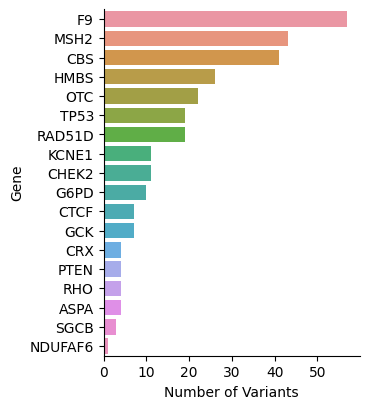

In [11]:
# g = sns.catplot(data=pillar_varchamp_by_var_df.unique(subset="gene_variant").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
#                 x="Number of Variants", y="Gene", kind="bar", height=4, aspect=.9)

### 3.2 Merge by genomic locations

In [42]:
varchamp_pillar_df = varchamp_clinvar_gnomad_df.join(
    pillar_clinvar_single_aa_df,
    on=["Chrom", "nuc_loc", "ref_allele", "alt_allele"],
    suffix="_pp",
    how="full",
    coalesce=True
)
display(varchamp_pillar_df.unique(subset="gene_variant"))
display(varchamp_pillar_df.drop_nulls(subset="pillar_tested").unique(subset="gene_variant"))

symbol,ensembl_gene_id,orf_id_wt,mutation_id_old,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,gene_variant,chr_num,nuc_loc,ref_allele,…,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,spdi_trimmed_pp
str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,i64,str,i64,str,i64,str,i64,str,str,i32,f64,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str
"""STXBP1""","""ENSG00000136854""",7652,1795,"""CCSBVarC007620""","""ALE00007606""","""NC_000009.12:127661161:A:C""","""385A>C""","""Thr129Pro""","""Edgotyping3""","""VUSMutGDEh008""","""F07""","""GDEhDisVCh_40016""","""E05""","""2""","""VUSMutGDDh008""","""F07""","""NULL""","""NULL""","""VUSMutpDEST2_06""","""B06""","""NULL""","""NULL""",1,"""1""",1,"""1""",0,"""NULL""",1,"""1""",0,"""NULL""","""STXBP1_Thr129Pro""",9,1.27661161e8,"""A""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""CCM2""",null,3928,null,"""CCSBVarC038741""",null,"""NC_000007.14:45072743:G:T""",null,"""Val255Leu""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""CCM2_Val255Leu""",7,4.5072743e7,"""G""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""CYP1B1""","""ENSG00000138061""",7267,216228,"""CCSBVarC006829""","""ALE00006827""","""NC_000002.12:38071195:C:T""","""1159G>A""","""Glu387Lys""","""CEGS2""","""CegsMutGDEh1027""","""H01""","""GDEhDisVCh_40027""","""A10""","""1""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",0,"""NULL""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""CYP1B1_Glu387Lys""",2,3.8071195e7,"""C""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""PYGM""","""ENSG00000068976""",53281,2843,"""CCSBVarC007986""","""ALE00007972""","""NC_000011.10:64758670:C:A""","""278G>T""","""Gly93Val""","""Edgotyping3""","""VUSMutGDEh006""","""A10""","""GDEhDisVCh_40017""","""F11""","""1""","""VUSMutGDDh006""","""A1

symbol,ensembl_gene_id,orf_id_wt,mutation_id_old,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,gene_variant,chr_num,nuc_loc,ref_allele,…,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,spdi_trimmed_pp
str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,i64,str,i64,str,i64,str,i64,str,str,i32,f64,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str
"""OTC""","""ENSG00000036473""",71569,205991,"""CCSBVarC005264""","""ALE00005264""","""NC_000023.11:38421050:T:C""","""1033T>C""","""Tyr345His""","""CEGS2""","""CegsMutGDEh1012""","""G03""","""GDEhDisVCh_40048""","""E02""","""2""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""2""",0,"""NULL""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""OTC_Tyr345His""",23,3.842105e7,"""T""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""OTC_Tyr345His""","""Tyr345His""",true,"""X:38421050:T:C"""
"""MSH2""",null,7918,null,"""CCSBVarC010936""",null,"""NC_000002.12:47410215:T:G""",null,"""Val163Gly""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""MSH2_Val163Gly""",2,4.7410215e7,"""T""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""MSH2_Val163Gly""","""Val163Gly""",true,"""2:47410215:T:G"""
"""MSH2""","""ENSG00000095002""",7918,202640,"""CCSBVarC003003""","""ALE00003003""","""NC_000002.12:47408463:C:G""","""274C>G""","""Leu92Val""","""CEGS2""","""CegsMutGDEh1039""","""G08""","""GDEhDisVCh_40060""","""B08""","""2""","""CegsMutGDDh1039""","""G08""","""NULL""","""NULL""","""VUSMutpDEST2_07""","""B03""","""NULL""","""NULL""",1,"""1""",1,"""1""",0,"""NULL""",1,"""1""",0,"""NULL""","""MSH2_Leu92Val""",2,4.7408463e7,"""C""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""MSH2_Leu92Val""","""Leu92Val""",true,"""2:47408463:C:G"""
"""HMBS""","""ENSG00000256269""",2803,200943,"""CCSBVarC005175""","""ALE00005175""","""NC_000011.10:119092506:G:A""","""754G>A""","""Ala252Thr""

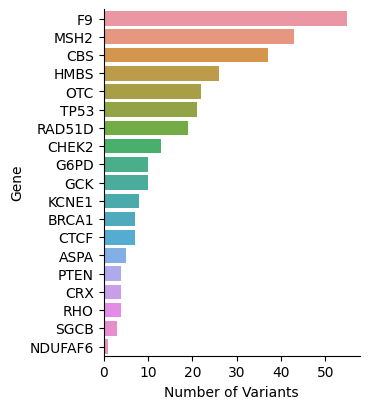

In [43]:
g = sns.catplot(data=varchamp_pillar_df.drop_nulls(subset="pillar_tested").unique(subset="gene_variant").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
                x="Number of Variants", y="Gene", kind="bar", height=4, aspect=.9)

In [45]:
varchamp_pillar_df.drop_nulls(subset="pillar_tested").filter(pl.col("gene_variant")==pl.col("gene_variant_pp")).unique(subset="gene_variant")

symbol,ensembl_gene_id,orf_id_wt,mutation_id_old,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,gene_variant,chr_num,nuc_loc,ref_allele,…,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,spdi_trimmed_pp
str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,i64,str,i64,str,i64,str,i64,str,str,i32,f64,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str
"""MSH2""",null,7918,null,"""CCSBVarC010964""",null,"""NC_000002.12:47410322:T:C""",null,"""Cys199Arg""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""MSH2_Cys199Arg""",2,4.7410322e7,"""T""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""MSH2_Cys199Arg""","""Cys199Arg""",true,"""2:47410322:T:C"""
"""OTC""","""ENSG00000036473""",71569,35642,"""CCSBVarC002762""","""ALE00002762""","""NC_000023.11:38411941:T:C""","""947T>C""","""Phe316Ser""","""RC4""","""RC4_Mut_GDEh1017""","""H11""","""GDEhDisVCh_40048""","""H11""","""2""","""RC4_Mut_GDDh1017""","""H11""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""6""",1,"""1""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""OTC_Phe316Ser""",23,3.8411941e7,"""T""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""OTC_Phe316Ser""","""Phe316Ser""",true,"""X:38411941:T:C"""
"""MSH2""","""ENSG00000095002""",7918,202667,"""CCSBVarC003010""","""ALE00003010""","""NC_000002.12:47445590:T:C""","""1319T>C""","""Leu440Pro""","""CEGS2""","""CegsMutGDEh1038""","""H01""","""GDEhDisVCh_40060""","""C07""","""2""","""CegsMutGDDh1038""","""H01""","""NULL""","""NULL""","""VUSMutpDEST2_07""","""H03""","""NULL""","""NULL""",1,"""1""",1,"""1""",0,"""NULL""",1,"""1""",0,"""NULL""","""MSH2_Leu440Pro""",2,4.744559e7,"""T""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""MSH2_Leu440Pro""","""Leu440Pro""",true,"""2:47445590:T:C"""
"""MSH2""","""ENSG00000095002""",7918,202658,"""CCSBVarC003006""","""ALE00003006""","""NC_000002.12:47416357:C:T""","""1004C>T""","""T

In [47]:
with pl.Config(tbl_rows=50):
    display(
        varchamp_pillar_df.drop_nulls(
            subset="pillar_tested"
        ).filter(
            pl.col("gene_variant")!=pl.col("gene_variant_pp")
        ).with_columns(
            pl.col("nuc_loc").cast(pl.Int32).alias("nuc_loc"),
            pl.col("gene_variant_pp").alias("gene_variant_pillar")
        ).select(
            pl.col(["gene_variant","gene_variant_pillar","Flag", "spdi", 
                    "Chrom", "nuc_loc", "ref_allele", "alt_allele", "hgvs_p", 
                    "auth_transcript_id", "Ref_seq_transcript_ID", "Ensembl_transript_ID"])
        ).unique(subset="gene_variant").sort("gene_variant")
    )

gene_variant,gene_variant_pillar,Flag,spdi,Chrom,nuc_loc,ref_allele,alt_allele,hgvs_p,auth_transcript_id,Ref_seq_transcript_ID,Ensembl_transript_ID
str,str,str,str,str,i32,str,str,str,str,str,str
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""",null,"""NC_000017.11:43063909:C:G""","""17""",43063909,"""C""","""G""","""p.Gly1706Ala""",null,"""NM_007294.4""","""ENST00000357654.9"""
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""",null,"""NC_000017.11:43051086:C:A""","""17""",43051086,"""C""","""A""","""p.Gly1770Val""",null,"""NM_007294.4""","""ENST00000357654.9"""
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""",null,"""NC_000017.11:43051104:A:G""","""17""",43051104,"""A""","""G""","""p.Leu1764Pro""",null,"""NM_007294.4""","""ENST00000357654.9"""
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""",null,"""NC_000017.11:43070929:A:G""","""17""",43070929,"""A""","""G""","""p.Phe1662Ser""",null,"""NM_007294.4""","""ENST00000357654.9"""
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""",null,"""NC_000017.11:43063941:A:T""","""17""",43063941,"""A""","""T""","""p.Phe1695Ile""",null,"""NM_007294.4""","""ENST00000357654.9"""
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""",null,"""NC_000017.11:43067628:G:A""","""17""",43067628,"""G""","""A""","""p.Thr1685Ile""",null,"""NM_007294.4""","""ENST00000357654.9"""
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""",null,"""NC_000017.11:43057122:A:G""","""17""",43057122,"""A""","""G""","""p.Val1736Ala""",null,"""NM_007294.4""","""ENST00000357654.9"""
"""CHEK2_Arg180Cys""","""CHEK2_Arg180""",null,"""NC_000022.11:28725031:G:A""","""22""",28725031,"""G""","""A""","""p.Arg180""",null,"""NM_007194.4""","""ENST00000404276.6"""
"""CHEK2_Glu239Lys""","""CHEK2_Glu239""",null,"""NC_000022.11:28711986:C:T""","""22""",28711986,"""C""","""T""","""p.Glu239""",null,"""NM_007194.4""","""ENST00000404276.6"""


In [48]:
varchamp_pillar_df.write_csv("../3_outputs/varchamp_alleles_with_pillar_annotations.tsv", separator="\t") #.unique(subset="spdi")

## 4. Merging alleles from Malvika's codes

Scripts provided by Malvika to merge the alleles from VarChAMP with alleles from the Pillar Project.

In [25]:
import re

pp = pd.read_csv("../1_inputs/raw_inputs/pillar_data/pillar_data_clinvar38_053125_wREVEL_gold_standards.csv", low_memory=False)
vc = pd.read_csv("../1_inputs/VarChampSeqConfirmationResult.tsv", sep="\t")

pattern = r'NC_0*(\d+)\.\d+:(\d+):([ACGT]):([ACGT])'
vc[['chromosome', 'position', 'ref', 'alt']] = vc['spdi'].str.extract(pattern)

#replace 23 with X and 24 with Y to match PP dataframe
vc['chromosome'] = vc['chromosome'].astype(str).replace({'23': 'X', '24': 'Y'})

vc['chromosome'] = vc['chromosome'].astype(str).str.strip()
pp['Chrom'] = pp['Chrom'].astype(str).str.strip()

vc['ref'] = vc['ref'].astype(str).str.strip()
vc['alt'] = vc['alt'].astype(str).str.strip()
pp['ref_allele'] = pp['ref_allele'].astype(str).str.strip()
pp['alt_allele'] = pp['alt_allele'].astype(str).str.strip()

vc['position'] = vc['position'].astype(float)
pp['hg38_start'] = pp['hg38_start'].astype(float)

vc["gene_variant"] = vc["symbol"].str.strip() + "_" + vc["aa_change"].str.strip()
# Now merge
check = pd.merge(vc, pp, 
                 left_on=['chromosome', 'position', 'ref', 'alt'],
                 right_on=['Chrom', 'hg38_start', 'ref_allele', 'alt_allele'],
                 how='inner')

In [ ]:
check_pl = pl.DataFrame(check)
check_pl["gene_variant"].unique()
nm = check[check['ID'].isna()]

In [ ]:
# check.to_csv("~/IGVF-cvfg-pillar-project/varchamp_matched_variants_pp_060825.csv", index = None)
# nm.to_csv("~/IGVF-cvfg-pillar-project/varchamp_unmatched_variants_pp_060825.csv", index = None)